# Ripple Time Series Prediction with LSTM

#### Import necessary library needed for the model training

In [ ]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import plotly.offline as py
import plotly.graph_objs as go
import numpy as np
import seaborn as sns
py.init_notebook_mode(connected=True)
%matplotlib inline

#### Read data set

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("team-ai/Ripple-price-prediction")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'bitcoin-price-prediction' dataset.
Path to dataset files: /kaggle/input/bitcoin-price-prediction


In [ ]:
data = pd.read_csv(filepath_or_buffer="/kaggle/input/Ripple-price-prediction/Ripple_price_Training - Training.csv", index_col="Date")

In [ ]:
import pandas as pd
import yfinance as yf
import datetime
from datetime import date, timedelta
today = date.today()

d1 = today.strftime("%Y-%m-%d")
end_date = d1
d2 = date.today() - timedelta(days=4745)
d2 = d2.strftime("%Y-%m-%d")
start_date = d2

data = yf.download('XRP-INR',
                      start=start_date,
                      end=end_date,
                      progress=False)
data["Date"] = data.index
data = data[["Date", "Open", "High", "Low", "Close", "Volume"]]
data.reset_index(drop=True, inplace=True)
print(data.head())

/tmp/ipython-input-1447279718.py:13: FutureWarning:

YF.download() has changed argument auto_adjust default to True



Price        Date       Open       High        Low      Close       Volume
Ticker               XRP-INR    XRP-INR    XRP-INR    XRP-INR      XRP-INR
0      2017-11-11  13.419571  13.973953  13.387708  13.711619   8764216001
1      2017-11-12  13.697544  13.697544  12.731547  12.858609  16366563521
2      2017-11-13  12.867276  13.353020  12.866233  13.311211   8673858810
3      2017-11-14  13.326717  13.981933  13.326717  13.722555   8329409400
4      2017-11-15  13.664480  13.924280  13.606993  13.897508   6545186440


In [ ]:
data.head()

Price,Date,Open,High,Low,Close,Volume
Ticker,,XRP-INR,XRP-INR,XRP-INR,XRP-INR,XRP-INR
0,2017-11-11,13.419571,13.973953,13.387708,13.711619,8764216001
1,2017-11-12,13.697544,13.697544,12.731547,12.858609,16366563521
2,2017-11-13,12.867276,13.353020,12.866233,13.311211,8673858810
3,2017-11-14,13.326717,13.981933,13.326717,13.722555,8329409400
4,2017-11-15,13.664480,13.924280,13.606993,13.897508,6545186440


In [ ]:
data.tail()

Price,Date,Open,High,Low,Close,Volume
Ticker,,XRP-INR,XRP-INR,XRP-INR,XRP-INR,XRP-INR
2877,2025-09-27,247.023544,250.616608,245.305725,248.983002,259333612582
2878,2025-09-28,248.981125,254.221207,245.626755,254.200378,293187940415
2879,2025-09-29,254.200470,258.653473,252.772278,255.707916,464975457954
2880,2025-09-30,255.705338,258.011078,250.383881,252.922897,442734609339
2881,2025-10-01,252.923889,262.376953,250.020645,261.374207,560557110144


#### View data info

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2882 entries, 0 to 2881
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   (Date, )           2882 non-null   datetime64[ns]
 1   (Open, XRP-INR)    2882 non-null   float64       
 2   (High, XRP-INR)    2882 non-null   float64       
 3   (Low, XRP-INR)     2882 non-null   float64       
 4   (Close, XRP-INR)   2882 non-null   float64       
 5   (Volume, XRP-INR)  2882 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 135.2 KB


#### View data rows

In [ ]:
data.head()

Price,Date,Open,High,Low,Close,Volume
Ticker,,XRP-INR,XRP-INR,XRP-INR,XRP-INR,XRP-INR
0,2017-11-11,13.419571,13.973953,13.387708,13.711619,8764216001
1,2017-11-12,13.697544,13.697544,12.731547,12.858609,16366563521
2,2017-11-13,12.867276,13.353020,12.866233,13.311211,8673858810
3,2017-11-14,13.326717,13.981933,13.326717,13.722555,8329409400
4,2017-11-15,13.664480,13.924280,13.606993,13.897508,6545186440


#### Check latest date of data

In [ ]:
data.tail()

Price,Date,Open,High,Low,Close,Volume
Ticker,,XRP-INR,XRP-INR,XRP-INR,XRP-INR,XRP-INR
2877,2025-09-27,247.023544,250.616608,245.305725,248.983002,259333612582
2878,2025-09-28,248.981125,254.221207,245.626755,254.200378,293187940415
2879,2025-09-29,254.200470,258.653473,252.772278,255.707916,464975457954
2880,2025-09-30,255.705338,258.011078,250.383881,252.922897,442734609339
2881,2025-10-01,252.923889,262.376953,250.020645,261.374207,560557110144


#### Plot line graph base on `Close`

In [ ]:
xrp_trace = go.Scatter(x=data.index, y=data['Close'], name= 'Price')
py.iplot([xrp_trace])

#### Fill value 0 data points on `Close` with NAN and then use ffill method to fill values

In [ ]:
data['Close'].replace(0, np.nan, inplace=True)
data['Close'].fillna(method='ffill', inplace=True)

/tmp/ipython-input-786103993.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-786103993.py:2: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

/tmp/ipython-input-786103993.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#### Plot new line graph again on `Close` with newly filled values

In [ ]:
xrp_trace = go.Scatter(x=data.index, y=data['Close'], name= 'Price')
py.iplot([xrp_trace])

### Using `Close` as a feature to train the LSTM model

#### Use MinMaxScaler to normalize `Close` to range from 0 to 1

In [ ]:
from sklearn.preprocessing import MinMaxScaler
values = data['Close'].values.reshape(-1,1)
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

#### Split 70% of data for training and 30% for testing

In [ ]:
train_size = int(len(scaled) * 0.7)
test_size = len(scaled) - train_size
train, test = scaled[0:train_size,:], scaled[train_size:len(scaled),:]
print(len(train), len(test))

2017 865


#### Create function for creating dataset with look back

In [ ]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

#### Generate dataset for trainX, trainY, testX, testY

In [ ]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

2016
864


#### Reshape X for model training

In [ ]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

#### Running the LSTM model with 300 epochs

In [ ]:
model = Sequential()
model.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history = model.fit(trainX, trainY, epochs=300, batch_size=100, validation_data=(testX, testY), verbose=0, shuffle=False)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



#### Plot line graph to show amount loss according the the epoch

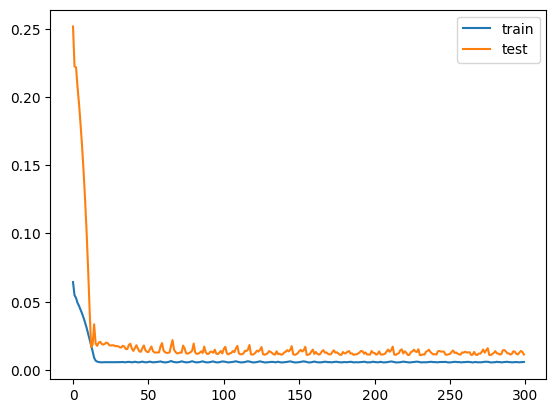

In [ ]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

#### Make prediction using textX and plotting line graph against testY

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


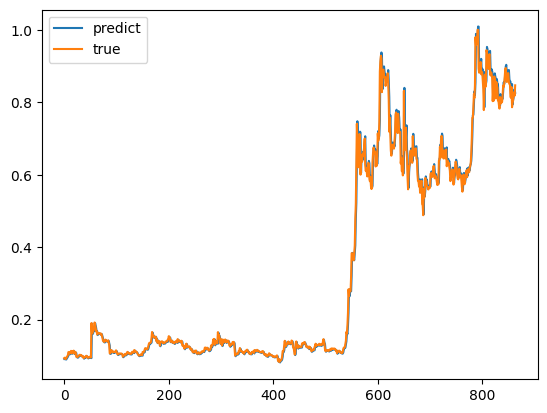

In [ ]:
yhat = model.predict(testX)
pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()